# Manipulación de datos ráster con GDAL

En esta sección, veremos ejemplos de manipulación de conjuntos de datos ráster con GDAL. Nos centraremos en estas operaciones comunes.

1. Conversión de formato
2. Recortar
3. Sobremuestreo/recuadriculado
4. Multiapariencia

Tenga en cuenta que no discutiremos la transformación de coordenadas o la conversión de proyección en esta sección. Discutiremos esos temas en una sección separada.

## Antes de empezar

En esta sección asumiremos que ha ejecutado los pasos de descarga de datos del cuaderno anterior '02_Intro_RasterData'. <b>Si aún no lo ha hecho, ¡la mayor parte de esta sección no funcionará!</b> Así que asegúrese de haber completado las descargas de datos de esa sección antes de continuar.

In [1]:
###Las importaciones habituales de python para el portátil
%matplotlib inline
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

gdal.UseExceptions()

#Función de utilidad para cargar datos
def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #matriz de datos
    data = ds.GetRasterBand(band).ReadAsArray()
    #Extensión del mapa
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent

## gdal_translate

Usaremos la utilidad **gdal_translate** ya sea como ejecutable o programáticamente para realizar todas las operaciones de manipulación de datos enumeradas anteriormente en este tutorial. Para obtener una lista de las opciones admitidas por **gdal_translate**, consulte

http://www.gdal.org/gdal_translate.html

```bash
gdal_translate [--help-general]
       [-ot {Byte/Int16/UInt16/UInt32/Int32/Float32/Float64/
             CInt16/CInt32/CFloat32/CFloat64}] [-strict]
       [-of format] [-b band]* [-mask band] [-expand {gray|rgb|rgba}]
       [-outsize xsize[%]|0 ysize[%]|0] [-tr xres yres]
       [-r {nearest,bilinear,cubic,cubicspline,lanczos,average,mode}]
       [-unscale] [-scale[_bn] [src_min src_max [dst_min dst_max]]]* [-exponent[_bn] exp_val]*
       [-srcwin xoff yoff xsize ysize] [-epo] [-eco]
       [-projwin ulx uly lrx lry] [-projwin_srs srs_def]
       [-a_srs srs_def] [-a_ullr ulx uly lrx lry] [-a_nodata value]
       [-a_scale value] [-a_offset value]
       [-gcp pixel line easting northing [elevation]]*
       |-colorinterp{_bn} {red|green|blue|alpha|gray|undefined}]
       |-colorinterp {red|green|blue|alpha|gray|undefined},...]
       [-mo "META-TAG=VALUE"]* [-q] [-sds]
       [-co "NAME=VALUE"]* [-stats] [-norat]
       [-oo NAME=VALUE]*
       src_dataset dst_dataset
```

### Conversión de formato

La conversión de datos ráster de un formato a otro es un requisito común para trabajar con código heredado. Si el software se creó con soporte GDAL, este paso sería opcional. Pero todos tenemos software escrito para trabajar con archivos binarios planos, geotiffs de banda única o archivos GMT grd. Estos son algunos ejemplos del uso de **gdal_translate** para convertir formatos.

#### Conversión de imágenes de una sola banda

In [2]:
#Convertir DEM de formato GMT a geotiff
!gdal_translate -of GTiff 18.grd 18.tif

Input file size is 1201, 601
0...10...20...30...40...50...60...70...80...90...100 - done.


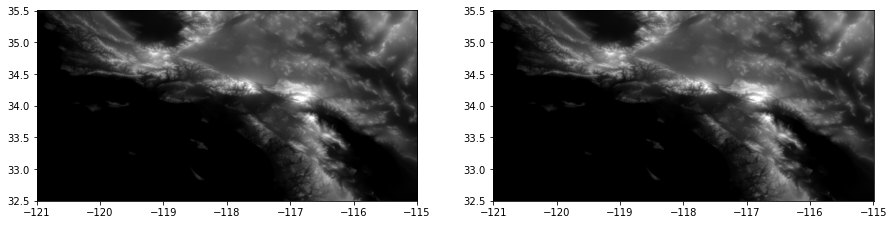

In [6]:
#Cargue y compare datos de ambos formatos
gmt, gmtext = loadData('18.grd')
tif, tifext = loadData('18.tif')
plt.figure('GMT vs TIFF',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(gmt, clim=[-7,2690], extent=gmtext, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(tif, clim=[-7,2690], extent=tifext, cmap='gray')
plt.show()
gmt = None
tif = None

<br>
<div class="alert alert-info">
<b>Nota:</b>

gdalinfo en el archivo convertido también informó un archivo **tif.aux.xml**. Esto se debe a que GDAL brinda soporte para traducir la información básica del ráster de uno a otro. Cada formato tiene su propio método personalizado para almacenar metadatos, que puede no ser compatible con otros formatos. En tales casos, GDAL creará un aux.xml para volcar los metadatos en él.

</div>

#### Convertir una sola banda y asignar NoDataValue

In [7]:
#Extraer capa de coherencia
!gdal_translate -of GTiff -b 2 -a_nodata 0 stripmap/interferogram/topophase.cor.geo.vrt stripmap/interferogram/coherence.geo.tif

Input file size is 2989, 3547
0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
#Mira la salida
!gdalinfo stripmap/interferogram/coherence.geo.tif

Driver: GTiff/GeoTIFF
Files: stripmap/interferogram/coherence.geo.tif
Size is 2989, 3547
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-155.392500000000013,19.995000000000001)
Pixel Size = (0.000277777777778,-0.000277777777778)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-155.3925000,  19.9950000) (155d23'33.00"W, 19d59'42.00"N)
Lower Left  (-155.3925000,  19.0097222) (155d23'33.00"W, 19d 0'35.00"N)
Upper 

#### Opciones de creación: características específicas del formato

Cada formato de datos tiene sus propias características especiales. Por ejemplo, muchos formatos incluyen compatibilidad con la compresión de datos para ahorrar espacio en disco. Al traducir datos a estos formatos, algunas de estas opciones se pueden habilitar agregando las opciones **-co**. Estas opciones son específicas de los formatos y se pueden descubrir a través de sus páginas de documentación. Por ejemplo:

* GeoTiff: http://www.gdal.org/frmt_gtiff.html
* netCDF: http://www.gdal.org/frmt_netcdf.html

In [9]:
#Crearemos un archivo de tipo flotante comprimido de 16 bits para mantener la coherencia con la compresión
!gdal_translate -of GTiff -b 2 -a_nodata 0 stripmap/interferogram/topophase.cor.geo.vrt stripmap/interferogram/coherence_compressed.geo.tif -co "NBITS=16" -co "COMPRESS=DEFLATE" 

Input file size is 2989, 3547
0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
#Mira los tamaños de los archivos
!ls -ltr stripmap/interferogram/*.tif

-rw-r--r--  1 javjrg  staff  42429592 Sep  8 10:30 stripmap/interferogram/coherence.geo.tif
-rw-r--r--  1 javjrg  staff  12983722 Sep  8 10:32 stripmap/interferogram/coherence_compressed.geo.tif


In [11]:
#Mira la salida
!gdalinfo stripmap/interferogram/coherence_compressed.geo.tif

Driver: GTiff/GeoTIFF
Files: stripmap/interferogram/coherence_compressed.geo.tif
Size is 2989, 3547
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-155.392500000000013,19.995000000000001)
Pixel Size = (0.000277777777778,-0.000277777777778)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-155.3925000,  19.9950000) (155d23'33.00"W, 19d59'42.00"N)
Lower Left  (-155.3925000,  19.0097222) (155d

#### Archivos binarios planos

GDAL admite una cantidad bastante grande de formatos de datos binarios sin procesar: ENVI, SRTM, ROI_PAC, ISCE, etc. Muchos de estos controladores son aportados por el usuario y están construidos sobre los mecanismos básicos de manejo de datos sin procesar en GDAL. ENVI es ampliamente utilizado en la industria y es posiblemente el más probado de los formatos de datos sin procesar. Si es absolutamente necesario utilizar formatos binarios sin formato para sus productos intermedios, le recomendamos que utilice el formato ENVI.

La compatibilidad con otros formatos sin procesar, especialmente ROI_PAC e ISCE, es limitada y puede perder la sincronización con el software que los genera.

## Recorte

El recorte de datos es una operación muy común. GDAL nos permite recortar datos utilizando coordenadas de mapas y ubicaciones de líneas/píxeles. Incluso permite ubicar mapas en un sistema de coordenadas distinto al utilizado por el ráster de origen.

<br>
<div class="alert alert-info">
<b>Nota:</b>

Puede usar archivos VRT para ahorrar espacio en disco. No tiene que crear imágenes rasterizadas recortadas a menos que sea absolutamente necesario.

</div>

### Recortar usando coordenadas de mapa

In [12]:
#Recortar en el mismo sistema de coordenadas que el ráster de origen
# ulx uly lrx lry
!gdal_translate -of VRT -b 2 -projwin -154.95 19.6 -154.75 19.4 stripmap/interferogram/topophase.cor.geo.vrt stripmap/coherence_crop.vrt

Input file size is 2989, 3547


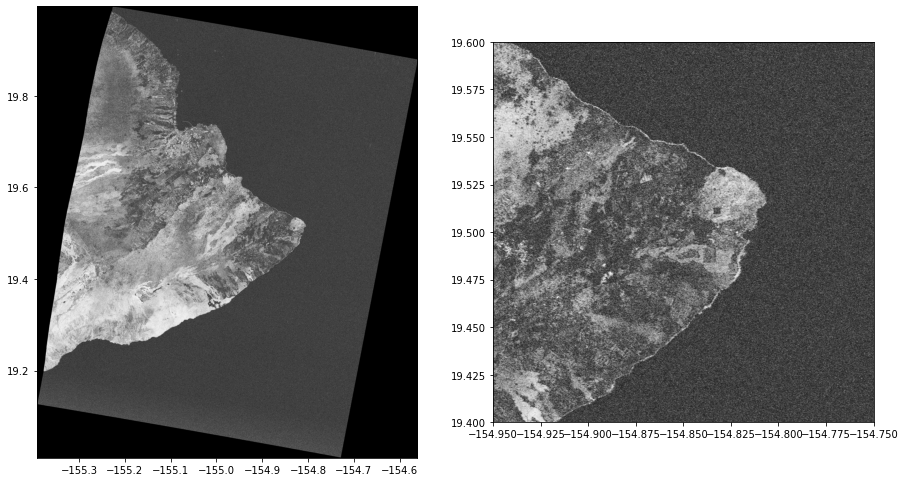

In [15]:
#Comparar datos originales y recortados
orig, origext = loadData('stripmap/interferogram/topophase.cor.geo.vrt', band=2)
crop, cropext = loadData('stripmap/coherence_crop.vrt')

plt.figure('Source vs Crop',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 1.], extent=origext, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(crop, clim=[0., 1.], extent=cropext, cmap='gray')
plt.show()

orig = None
crop= None

### Recortar usando coordenadas de mapa pero con un sistema de coordenadas diferente

Usaremos un DEM de Groenlandia en proyección estereográfica polar (EPSG:3413) para este ejemplo. Esto se logra usando el argumento **-projwin_srs** para **gdal_translate**

In [16]:
#Mira los datos de entrada
!gdalinfo Greenland1km.nc

Driver: netCDF/Network Common Data Format
Files: Greenland1km.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#comments=The data in this file was interpolated onto a 1km grid using natural neighbor interpolation which is based on Delauney triangulation.  This was accomplished using the function natgridd (see http://www.ncarg.ucar.edu//ngmath/natgrid/nnhome.html) from the National Center for Atmospheric Research (NCAR).  Natgrid is part of the NCAR Command Language (NCL) package which can be downloaded via http://www.ncl.ucar.edu/Download/
  NC_GLOBAL#creator=Glen D. Granzow
  NC_GLOBAL#Date=1 November 2010
  NC_GLOBAL#institution=University of Montana
  NC_GLOBAL#title=Greenland 1 km Data Set
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"Greenland1km.nc":presprcp
  SUBDATASET_1_DESC=[1x2801x1501] lwe_precipitation_rate (32-bit floating-point)
  SUBDATASET_2_NAME=NETCDF:"Greenland1km.nc":bheatflx
  SUBDATASET_2_DESC=[1x2801x1501] upward_geothermal_flux_at_ice_base (32-bit floating-point)
  SUBDATAS

In [17]:
#Recortar DEM usando coordenadas lat/lon
# ulx uly rlx rly
!gdal_translate -of VRT -projwin -55 71 -50 69 -projwin_srs EPSG:4326 NETCDF:"Greenland1km.nc":topg Greenland_crop.vrt

Input file size is 1501, 2801


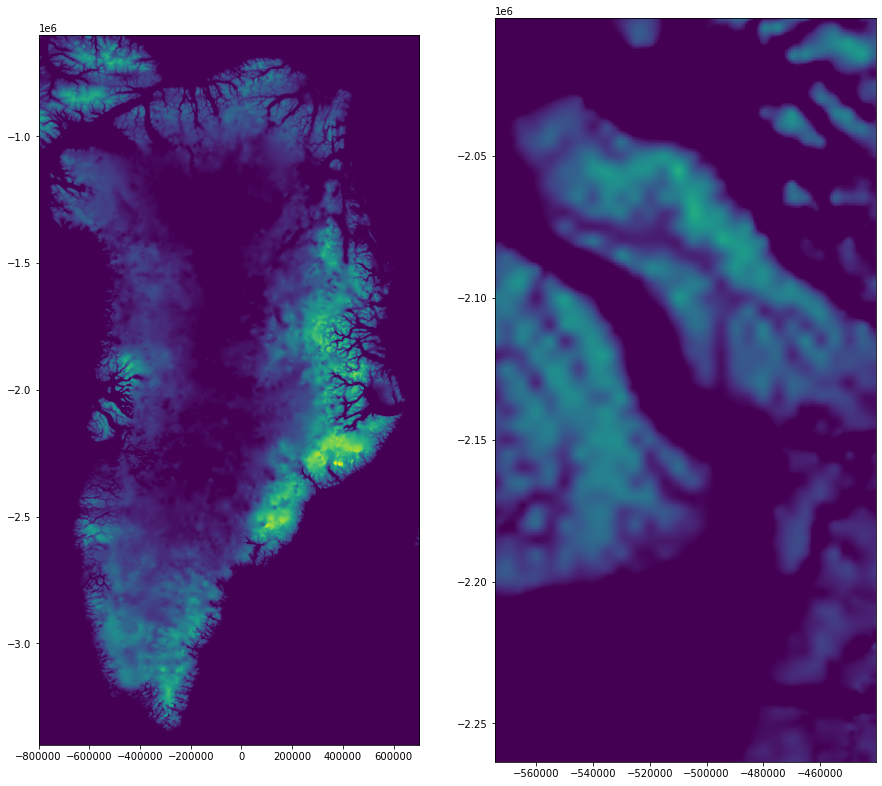

In [18]:
#Comparar datos originales y recortados
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
crop, cropext = loadData('Greenland_crop.vrt')

plt.figure('Source vs Crop 2',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 3000.], extent=origext)
plt.subplot(1,2,2)
plt.imshow(crop, clim=[0., 3000.], extent=cropext)
plt.show()

orig = None
crop= None

### Recortar utilizando ubicaciones de línea/píxel

También se pueden recortar imágenes utilizando las ubicaciones de líneas y píxeles. Esto es particularmente útil cuando se trabaja con rásteres que no están geocodificados. En nuestro caso, los productos de geometría de radar de recorte se pueden lograr utilizando este enfoque. Se debe usar el argumento **-srcwin** para especificar la región de interés.

In [19]:
#-srcwin xoff yoff xsize ysize
!gdal_translate -of VRT -srcwin 1400 1700 1200 1200 N33W119_wgs84.tif SRTM_crop.vrt

Input file size is 3600, 3600


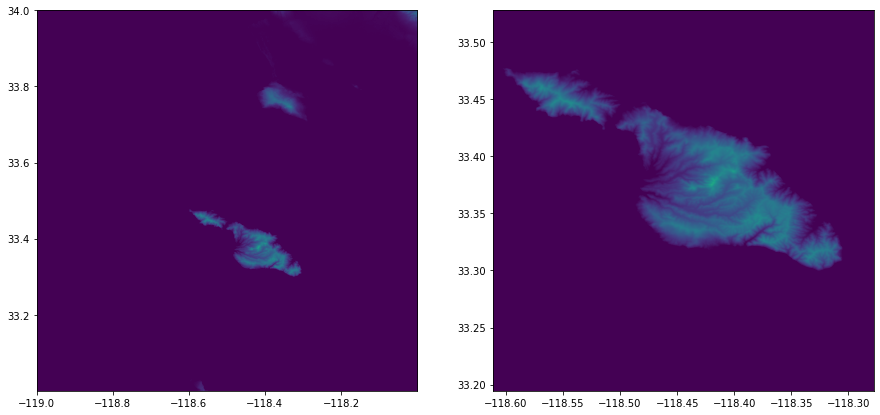

In [20]:
#Comparar datos originales y recortados
orig, origext = loadData('N33W119_wgs84.tif')
crop, cropext = loadData('SRTM_crop.vrt')

plt.figure('Source vs Crop 3',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 1000.], extent=origext)
plt.subplot(1,2,2)
plt.imshow(crop, clim=[0., 1000.], extent=cropext)
plt.show()

orig = None
crop= None

Recuerde el diseño ráster del tutorial sobre **Introducción a los datos ráster**. **xoff, yoff** hace referencia a la esquina superior izquierda del primer píxel de la región de interés. **xsize, ysize** se refiere al número de píxeles y líneas en la región de interés.

## Sobremuestreo / recuadriculado

El sobremuestreo o la recuadrícula son otras operaciones comunes de manipulación de datos. A menudo necesitamos volver a agrupar datos de diferentes fuentes para usarlos dentro de las mismas herramientas. Un ejemplo típico es el sobremuestreo del DEM. GDAL brinda soporte eficiente para ciertos tipos de interpoladores para sobremuestrear o volver a cuadricular los datos. De forma predeterminada, los siguientes interpoladores están disponibles

1. Vecino más cercano
2. Bilineal
3. cúbico
4. Ranura cúbica
5. Lanczos (sincronización truncada)
6. Promedio
7. Modo

El formato de salida puede volver a ser VRT si es necesario. Esto se recomienda si los datos sobremuestreados/recuadrados son un producto intermedio y no se van a utilizar una y otra vez. Cuando se utiliza el formato de salida VRT, el remuestreo/recuadrado se produce sobre la marcha cuando se lee el conjunto de datos.

### Rectificado con espaciamiento de muestras

Se puede proporcionar directamente el espaciado de muestra para volver a cuadricular los datos usando el argumento **-tr**.

In [21]:
#Sobremuestra Groenlandia dem a 500m
!gdal_translate -of GTiff -tr 500 500 -r cubicspline NETCDF:"Greenland1km.nc":topg Greenland_500m.tif

Input file size is 1501, 2801
0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
#¡Comprueba el espaciado de píxeles si quieres!
!gdalinfo Greenland_500m.tif

Driver: GTiff/GeoTIFF
Files: Greenland_500m.tif
Size is 3002, 5602
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Polar Stereographic (variant B)",
        METHOD["Polar Stereographic (variant B)",
            ID["EPSG",9829]],
        PARAMETER["Latitude of standard parallel",71,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8832]],
        PARAMETER["Longitude of origin",-39,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8833]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2]

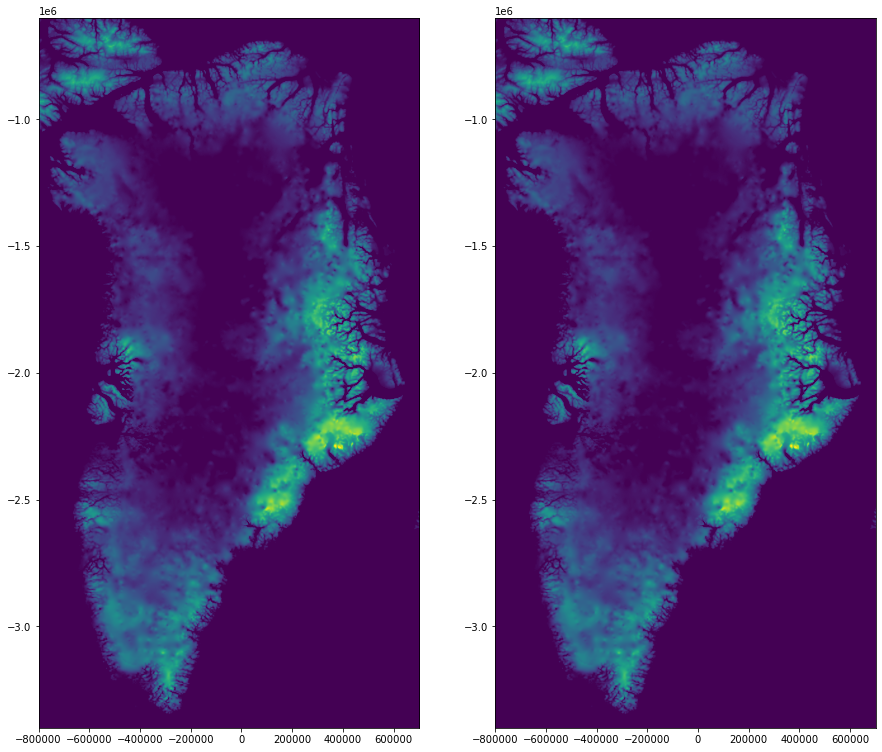

In [23]:
#Comparar datos originales y remuestreados
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
grid, gridext = loadData('Greenland_500m.tif')

plt.figure('Greenland',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 3000.], extent=origext)
plt.subplot(1,2,2)
plt.imshow(grid, clim=[0., 3000.], extent=gridext)
plt.show()

orig = None
grid = None

### Rectificado con tamaño de salida

También se puede especificar directamente el tamaño de salida esperado y **gdal_translate** calculará automáticamente el espaciado de píxeles correspondiente.

In [24]:
#Groenlandia DEM reducido a 60, 110
!gdal_translate -of GTiff -outsize 60 110 -r nearest NETCDF:"Greenland1km.nc":topg Greenland_subsample.tif

Input file size is 1501, 2801
0...10...20...30...40...50...60...70...80...90...100 - done.


In [25]:
#¡Comprueba el espaciado de píxeles si quieres!
!gdalinfo Greenland_subsample.tif

Driver: GTiff/GeoTIFF
Files: Greenland_subsample.tif
Size is 60, 110
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Polar Stereographic (variant B)",
        METHOD["Polar Stereographic (variant B)",
            ID["EPSG",9829]],
        PARAMETER["Latitude of standard parallel",71,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8832]],
        PARAMETER["Longitude of origin",-39,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8833]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,

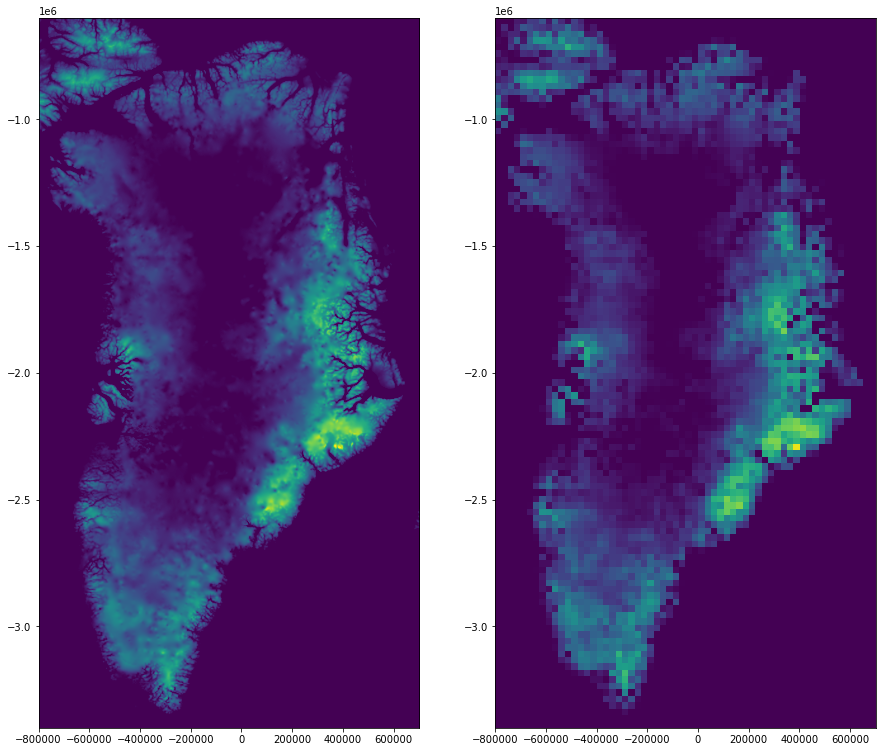

In [26]:
#Comparar datos originales y remuestreados
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
grid, gridext = loadData('Greenland_subsample.tif')

plt.figure('Greenland 2',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 3000.], extent=origext)
plt.subplot(1,2,2)
plt.imshow(grid, clim=[0., 3000.], extent=gridext)
plt.show()

orig = None
grid = None

### Rectificado con tamaño relativo

Alternativamente, **-outsize** también puede aceptar tamaño relativo en porcentajes.

In [27]:
!gdal_translate -of GTiff -outsize 10% 10% NETCDF:"Greenland1km.nc":topg Greenland_10perc.tif

Input file size is 1501, 2801
0...10...20...30...40...50...60...70...80...90...100 - done.


In [28]:
#¡Comprueba el espaciado de píxeles si quieres!
!gdalinfo Greenland_10perc.tif

Driver: GTiff/GeoTIFF
Files: Greenland_10perc.tif
Size is 150, 280
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Polar Stereographic (variant B)",
        METHOD["Polar Stereographic (variant B)",
            ID["EPSG",9829]],
        PARAMETER["Latitude of standard parallel",71,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8832]],
        PARAMETER["Longitude of origin",-39,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8833]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2]

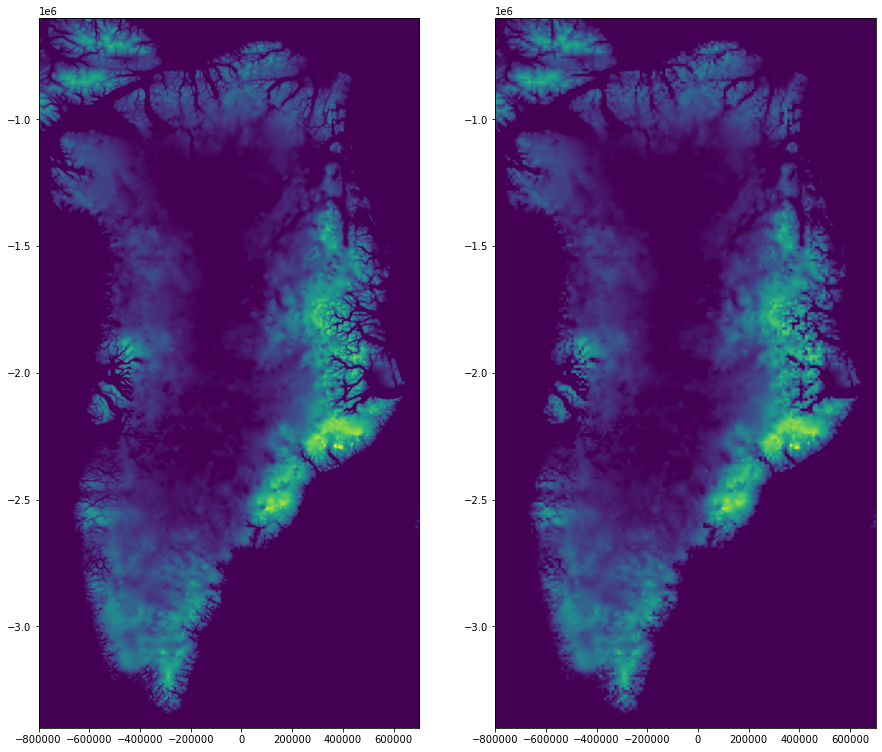

In [30]:
#Comparar datos originales y remuestreados
orig, origext = loadData('NETCDF:"Greenland1km.nc":topg')
grid, gridext = loadData('Greenland_10perc.tif')

plt.figure('Greenland 3',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 3000.], extent=origext)
plt.subplot(1,2,2)
plt.imshow(grid, clim=[0., 3000.], extent=gridext)
plt.show()

orig = None
grid = None

## Multilooking

Multilooking es una operación muy común en el procesamiento SAR/InSAR. En los casos más comunes, los datos se reducen utilizando un filtro de caja simple. Esto se puede lograr fácilmente mediante la manipulación de los parámetros **-outsize** y **-srcwin**. Aquí, configuraremos una función de python simple para buscar múltiples datos usando GDAL.

In [31]:
def multiLook(infile, outfile, fmt='GTiff', xlooks=None, ylooks=None, noData=None, method='average'):
    '''
    infile - Archivo de entrada a multilook
    outfile - Archivo de salida a multilook
    fmt - Formato de salida
    xlooks - Número de miradas en la dirección x/range
    ylooks - Número de miradas en la dirección y/azimuth
    '''
    ds = gdal.Open(infile, gdal.GA_ReadOnly)

    #Dimensiones del archivo de entrada
    xSize = ds.RasterXSize
    ySize = ds.RasterYSize

    #Dimensiones del archivo de salida
    outXSize = xSize//xlooks
    outYSize = ySize//ylooks

    ##Configurar opciones de traducción
    gdalTranslateOpts = gdal.TranslateOptions(format=fmt, 
                                              width=outXSize, height=outYSize,
                                             srcWin=[0,0,outXSize*xlooks, outYSize*ylooks],
                                             noData=noData, resampleAlg=method)

    #Llamar a gdal_translate
    gdal.Translate(outfile, ds, options=gdalTranslateOpts)       
    ds = None

Intentaremos usar esta función en algunos conjuntos de datos de valor real.

### Datos de valor real

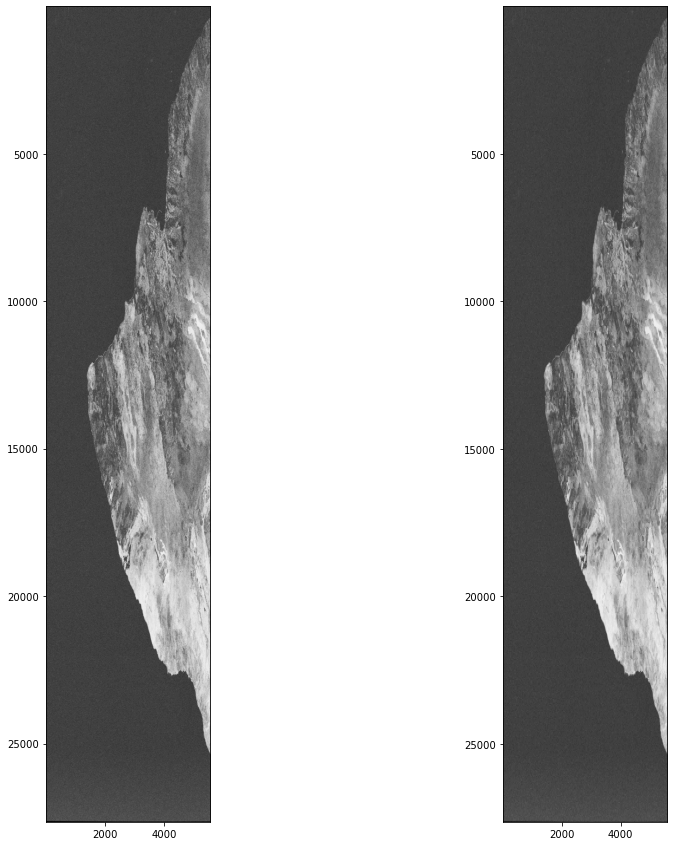

In [32]:
#Multilook el archivo de coherencia y luego visualice la salida
multiLook('stripmap/interferogram/topophase.cor.vrt', 'stripmap/coherence_looks.tif', 
          xlooks=5, ylooks=5, noData=0)

orig, origext = loadData('stripmap/interferogram/topophase.cor.vrt', band=2)
grid, gridext = loadData('stripmap/coherence_looks.tif', band=2)

plt.figure('Multilook',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(orig, clim=[0., 1.], extent=origext, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grid, clim=[0., 1.], extent=gridext, cmap='gray')
plt.show()

orig = None
grid = None

### Datos de valor complejo

<br>
<div class="alert alert-info">
<b>Nota:</b>
<ul>
<li> GDAL ha sido altamente optimizado para su uso con conjuntos de datos de valor real. Algunas funciones, como el filtro promedio, aún se están implementando para datos complejos. Utilizaremos una solución alternativa al tratar las partes real/imag como canales independientes de valor real. </li>

<li> La compatibilidad de GDAL con NoDataValue para conjuntos de datos complejos sigue evolucionando. Actualmente, esto solo está implementado en la API de C++. Con suerte, esto será expuesto a los usuarios en un futuro próximo. </li>

<li> Se espera que el soporte de datos complejos se implemente en los próximos 6 meses.</li>
</ul>
</div>

In [33]:
###Este es un arreglo temporal.
###Se espera que GDAL admita promediar y reconocer nodatos para datos complejos en un futuro próximo
###Incluimos este ejemplo para demostrar el uso de archivos en memoria/temporales

def multiLookCpx(infile, outfile, fmt='GTiff', xlooks=None, ylooks=None, noData=None, method='average'):
    '''
    infile - Archivo de entrada a multilook
    outfile - Archivo de salida a multilook
    fmt - Formato de salida
    xlooks - Número de miradas en la dirección x/range
    ylooks - Número de miradas en la dirección y/azimuth
    
    
    archivo cpx de entrada
         |
     2 bandas reales virtuales
         |
     2 bandas real multimirada virtual
         |
     1 banda complejo virtual
         |
     archivo cpx de salida
        
    '''
    sourcexml = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>1</SourceBand>
    </SimpleSource>'''.format(infile)
    
    ds = gdal.Open(infile, gdal.GA_ReadOnly)

    #Dimensiones del archivo de entrada
    xSize = ds.RasterXSize
    ySize = ds.RasterYSize

    #Dimensiones del archivo de salida
    outXSize = xSize//xlooks
    outYSize = ySize//ylooks

    #nombres de archivos temporales
    inmemfile = '/vsimem/cpxlooks.2band.vrt'
    inmemfile2 = '/vsimem/cpxlooks.multilooks.2band.vrt'
    inmemfile3 = '/vsimem/cpxlooks.combine.vrt'
    
    ##Aquí es donde lo convertimos en bandas reales y multilook.
    #Crear driver
    driver = gdal.GetDriverByName('VRT')
    rivrtds = driver.Create(inmemfile,xSize, ySize, 0)
    
    #Crear banda real
    options = ['subClass=VRTDerivedRasterBand',
               'PixelFunctionType=real',
               'SourceTransferType=CFloat32']
    rivrtds.AddBand(gdal.GDT_Float32, options)
    rivrtds.GetRasterBand(1).SetMetadata({'source_0' : sourcexml}, 'vrt_sources')
    
    #Crear banda imaginaria
    options = ['subClass=VRTDerivedRasterBand',
               'PixelFunctionType=imag',
               'SourceTransferType=CFloat32']
    rivrtds.AddBand(gdal.GDT_Float32, options)
    rivrtds.GetRasterBand(2).SetMetadata({'source_0' : sourcexml}, 'vrt_sources')
    
    ##Agregar información de proyección
    rivrtds.SetProjection(ds.GetProjection())
    ds = None
    

    ##Configurar opciones de traducción
    gdalTranslateOpts = gdal.TranslateOptions(format='VRT', 
                                              width=outXSize, height=outYSize,
                                             srcWin=[0,0,outXSize*xlooks, outYSize*ylooks],
                                             noData=noData, resampleAlg=method)

    #Aplicar multilook en canales reales e imágenes.
    mlvrtds = gdal.Translate(inmemfile2, rivrtds, options=gdalTranslateOpts)
    rivrtds = None
    mlvrtds = None
        
    #Escribir desde la memoria a VRT usando funciones de píxeles
    mlvrtds = gdal.OpenShared(inmemfile2)
    cpxvrtds = driver.Create(inmemfile3, outXSize, outYSize, 0)
    cpxvrtds.SetProjection(mlvrtds.GetProjection())
    cpxvrtds.SetGeoTransform(mlvrtds.GetGeoTransform())


    options = ['subClass=VRTDerivedRasterBand',
               'pixelFunctionType=complex',
               'sourceTransferType=CFloat32']
    xmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    md = {'source_0': xmltmpl.format(inmemfile2, 1),
          'source_1': xmltmpl.format(inmemfile2, 2)}

    cpxvrtds.AddBand(gdal.GDT_CFloat32, options)
    cpxvrtds.GetRasterBand(1).SetMetadata(md, 'vrt_sources')
    mlvrtds = None
        
        
    ###Ahora cree una copia al formato necesario
    driver = gdal.GetDriverByName(fmt)
    outds = driver.CreateCopy(outfile, cpxvrtds)
    cpxvrtds = None
    
    outds = None
    gdal.Unlink(inmemfile)
    gdal.Unlink(inmemfile2)
    gdal.Unlink(inmemfile3)
            

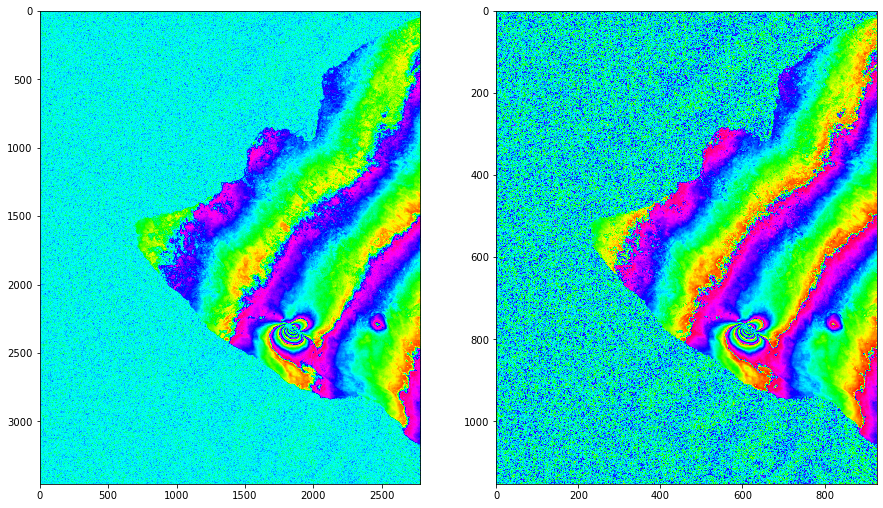

In [34]:
import numpy as np
import os

#Multilook el archivo de coherencia y luego visualice la salida
multiLookCpx('stripmap/interferogram/topophase.flat.vrt', 'stripmap/flattened_3x.tif', 
          xlooks=3, ylooks=3, noData='0')

orig, origext = loadData('stripmap/interferogram/topophase.flat.vrt')
grid, gridext = loadData('stripmap/flattened_3x.tif')

plt.figure('Multilook 2',figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.angle(orig), clim=[-np.pi, np.pi], extent=origext, cmap='hsv')
plt.subplot(1,2,2)
plt.imshow(np.angle(grid), clim=[-np.pi, np.pi], extent=gridext, cmap='hsv')
plt.show()

orig = None
grid = None

## Otras características a tener en cuenta

1. **gdaldem** es una utilidad que permite aplicar paletas de colores a imágenes rasterizadas. Muy rápido y puede usar paletas de colores personalizadas. Compatible con los archivos cpt de GMT. (http://www.gdal.org/gdaldem.html)

2. **gdal_rasterize** permite a los usuarios rasterizar archivos de formas/formatos vectoriales. (http://www.gdal.org/gdal_rasterize.html)

3. **gdal_edit.py** permite a los usuarios editar metadatos ráster en la línea de comando. (http://www.gdal.org/gdal_edit.html)